In [1]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from config_loader import load_config
import json
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
config, config_dir = load_config()

household_id = '05'
threshold = 0.1
env = config['Settings']['environment']
data_path = config[env]['data_path']
column_names_file = config['Data']['training_dataset_columns_file']
demo_inferred_data_file = config['Data']['inferred_data_file']
demo_dataset_ground_truth_file = config['Data']['demo_dataset_ground_truth_file']

In [3]:
def print_zero_one_distribution(df, name):
    print(f"\n{name} Zero/One Distribution (%):")
    for col in df.columns:
        zeros = (df[col] == 0).mean() * 100
        ones = (df[col] == 1).mean() * 100
        print(f"{col:<18}  0: {zeros:5.2f}%   1: {ones:5.2f}%")

In [4]:
# Read appliance names from the text file
with open(os.path.join(data_path, column_names_file), 'r') as file:
    column_names_json = json.load(file)

appliance_order = column_names_json['appliances']

Ground truth

In [5]:
ground_truth = pd.read_parquet(os.path.join(data_path, demo_dataset_ground_truth_file))
ground_truth = ground_truth.drop(columns=["household_id"])
ground_truth = ground_truth.drop(columns=["timestamp"])

ground_truth_binary = (ground_truth > threshold).astype(int)

print_zero_one_distribution(ground_truth_binary, "Ground Truth")


Ground Truth Zero/One Distribution (%):
Coffee Machine      0: 95.71%   1:  4.29%
Dryer               0: 100.00%   1:  0.00%
Freezer             0: 100.00%   1:  0.00%
Fridge              0:  0.03%   1: 99.97%
Lamp                0: 100.00%   1:  0.00%
Laptop              0: 100.00%   1:  0.00%
Microwave           0:  0.00%   1: 100.00%
PC                  0:  0.00%   1: 100.00%
Router              0: 100.00%   1:  0.00%
Tablet              0:  0.00%   1: 100.00%
Washing Machine     0: 100.00%   1:  0.00%
Other               0:  0.02%   1: 99.98%


Baseline all 0s

In [6]:
# Create a DataFrame of zeros with the same shape and columns as prediction_binary
all_off_baseline = pd.DataFrame(
    data=0,
    index=ground_truth_binary.index,
    columns=ground_truth_binary.columns
)

# Baseline accuracy: predicting all appliances as off
baseline_accuracy = accuracy_score(
    ground_truth_binary.values.flatten(),
    all_off_baseline.values.flatten()
)

print(f"Baseline accuracy (all appliances off): {baseline_accuracy * 100:.2f}%")
for col in ground_truth.columns:
    acc = accuracy_score(ground_truth_binary[col], all_off_baseline[col])
    print(f"Accuracy {col}: {acc * 100:.2f}%")


Baseline accuracy (all appliances off): 57.98%
Accuracy Coffee Machine: 95.71%
Accuracy Dryer: 100.00%
Accuracy Freezer: 100.00%
Accuracy Fridge: 0.03%
Accuracy Lamp: 100.00%
Accuracy Laptop: 100.00%
Accuracy Microwave: 0.00%
Accuracy PC: 0.00%
Accuracy Router: 100.00%
Accuracy Tablet: 0.00%
Accuracy Washing Machine: 100.00%
Accuracy Other: 0.02%


Baseline all 1s

In [7]:
# Create a DataFrame of zeros with the same shape and columns as prediction_binary
all_on_baseline = pd.DataFrame(
    data=1,
    index=ground_truth_binary.index,
    columns=ground_truth_binary.columns
)

# Baseline accuracy: predicting all appliances as off
baseline_accuracy = accuracy_score(
    ground_truth_binary.values.flatten(),
    all_on_baseline.values.flatten()
)

print(f"Baseline accuracy (all appliances on): {baseline_accuracy * 100:.2f}%")
for col in ground_truth.columns:
    acc = accuracy_score(ground_truth_binary[col], all_on_baseline[col])
    print(f"Accuracy {col}: {acc * 100:.2f}%")


Baseline accuracy (all appliances on): 42.02%
Accuracy Coffee Machine: 4.29%
Accuracy Dryer: 0.00%
Accuracy Freezer: 0.00%
Accuracy Fridge: 99.97%
Accuracy Lamp: 0.00%
Accuracy Laptop: 0.00%
Accuracy Microwave: 100.00%
Accuracy PC: 100.00%
Accuracy Router: 0.00%
Accuracy Tablet: 100.00%
Accuracy Washing Machine: 0.00%
Accuracy Other: 99.98%


Baseline random

In [8]:
# Create a random 0/1 DataFrame with the same shape and columns
np.random.seed(42)  # For reproducibility
random_baseline = pd.DataFrame(
    data=np.random.randint(0, 2, size=ground_truth_binary.shape),
    index=ground_truth_binary.index,
    columns=ground_truth_binary.columns
)

# Compute overall accuracy of the random baseline
random_accuracy = accuracy_score(
    ground_truth_binary.values.flatten(),
    random_baseline.values.flatten()
)
print(f"\nBaseline accuracy (random 0/1): {random_accuracy * 100:.2f}%")

# Compute per-appliance accuracy
for col in ground_truth.columns:
    acc = accuracy_score(ground_truth_binary[col], random_baseline[col])
    print(f"Accuracy {col}: {acc * 100:.2f}%")


Baseline accuracy (random 0/1): 49.99%
Accuracy Coffee Machine: 50.10%
Accuracy Dryer: 49.88%
Accuracy Freezer: 49.92%
Accuracy Fridge: 50.03%
Accuracy Lamp: 49.93%
Accuracy Laptop: 49.96%
Accuracy Microwave: 49.91%
Accuracy PC: 50.02%
Accuracy Router: 50.02%
Accuracy Tablet: 49.99%
Accuracy Washing Machine: 50.10%
Accuracy Other: 50.03%


Predictions

In [9]:
def plot_conf_matrix(y_true, y_pred, appliance_name):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    matrix = [[tn, fp],
              [fn, tp]]

    plt.figure(figsize=(4, 3))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: OFF', 'Pred: ON'],
                yticklabels=['True: OFF', 'True: ON'])

    plt.title(f'Confusion Matrix: {appliance_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()



Prediction Zero/One Distribution (%):
Coffee Machine      0: 82.53%   1: 17.47%
Dryer               0: 40.65%   1: 59.35%
Freezer             0:  0.00%   1: 100.00%
Fridge              0:  1.76%   1: 98.24%
Lamp                0: 37.06%   1: 62.94%
Laptop              0:  3.05%   1: 96.95%
Microwave           0:  0.00%   1: 100.00%
PC                  0:  0.00%   1: 100.00%
Router              0:  0.00%   1: 100.00%
Tablet              0:  0.00%   1: 100.00%
Washing Machine     0: 31.39%   1: 68.61%
Other               0:  0.00%   1: 100.00%
Total Accuracy: 58.04%
Total Precision: 83.63%

 Appliance: Coffee Machine
  Accuracy : 86.07%
  Precision: 22.42%
  Recall   : 91.34%
  F1 Score : 36.00%


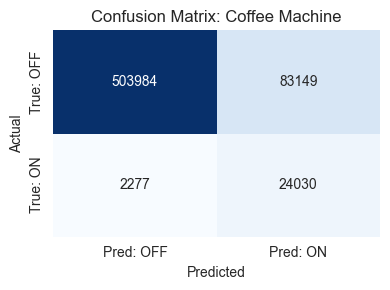


 Appliance: Dryer
  Accuracy : 40.65%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


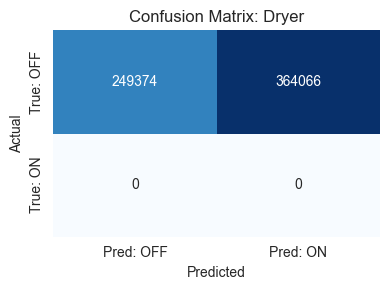


 Appliance: Freezer
  Accuracy : 0.00%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


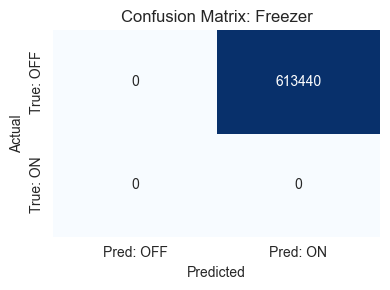


 Appliance: Fridge
  Accuracy : 98.21%
  Precision: 99.97%
  Recall   : 98.24%
  F1 Score : 99.10%


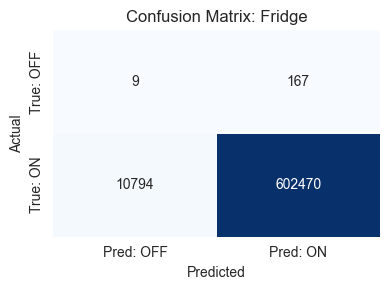


 Appliance: Lamp
  Accuracy : 37.06%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


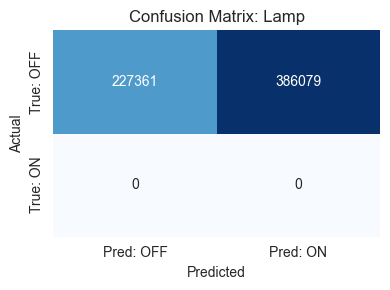


 Appliance: Laptop
  Accuracy : 3.05%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


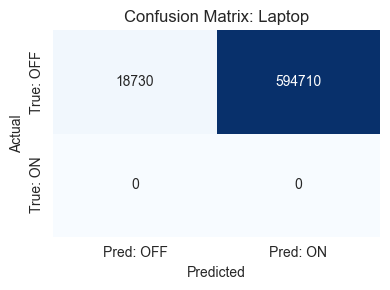


 Appliance: Microwave
  Accuracy : 100.00%
  Precision: 100.00%
  Recall   : 100.00%
  F1 Score : 100.00%


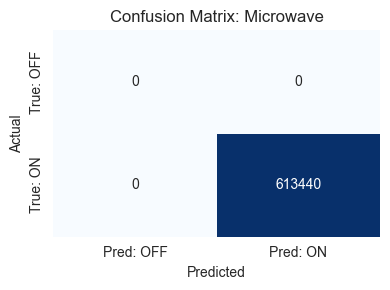


 Appliance: PC
  Accuracy : 100.00%
  Precision: 100.00%
  Recall   : 100.00%
  F1 Score : 100.00%


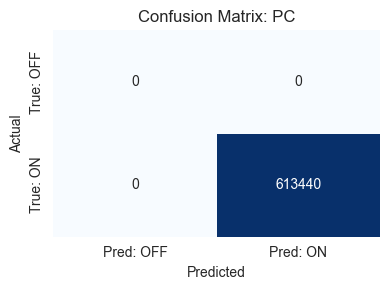


 Appliance: Router
  Accuracy : 0.00%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


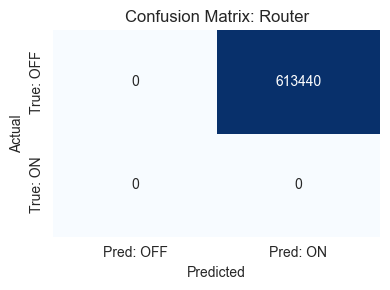


 Appliance: Tablet
  Accuracy : 100.00%
  Precision: 100.00%
  Recall   : 100.00%
  F1 Score : 100.00%


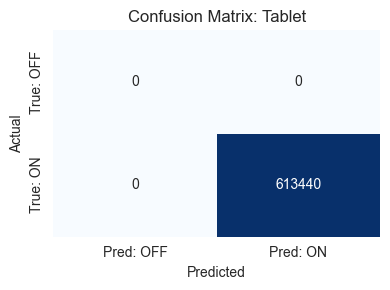


 Appliance: Washing Machine
  Accuracy : 31.39%
  Precision: 0.00%
  Recall   : 0.00%
  F1 Score : 0.00%


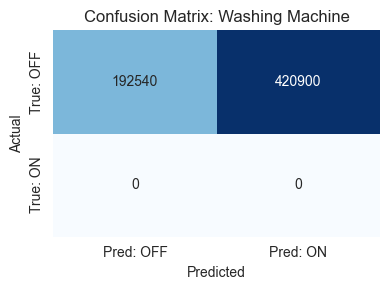


 Appliance: Other
  Accuracy : 99.98%
  Precision: 99.98%
  Recall   : 100.00%
  F1 Score : 99.99%


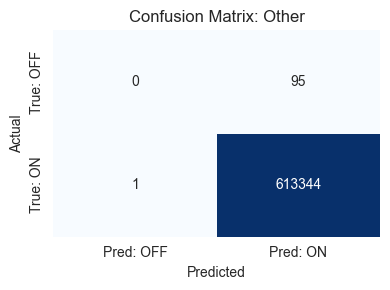

In [10]:
prediction = pd.read_parquet(os.path.join(data_path, demo_inferred_data_file))

prediction["timestamp"] = pd.to_datetime(prediction["timestamp"])

prediction["household_id"] = household_id

prediction_wide = prediction.pivot_table(
    index=["timestamp", "household_id"],
    columns="appliance",
    values="value",
    aggfunc="first"
).reset_index()

prediction_wide.columns.name = None

column_order = [col for col in appliance_order if col != "timestamp" and col != "household_id"]
prediction_wide = prediction_wide[["timestamp"] + column_order]

prediction_wide = prediction_wide.drop(columns=["timestamp"])

prediction_binary = (prediction_wide > threshold).astype(int)

print_zero_one_distribution(prediction_binary, "Prediction")

overall_accuracy = accuracy_score(
    ground_truth_binary.values.flatten(),
    prediction_binary.values.flatten()
)

overall_prediction_ratio = prediction_binary.values.flatten().mean()


print(f"Total Accuracy: {overall_accuracy * 100:.2f}%")
print(f'Total Precision: {overall_prediction_ratio * 100:.2f}%')

"""
for col in ground_truth.columns:
    acc = accuracy_score(y_true=ground_truth_binary[col], y_pred=prediction_binary[col])
    print(f"Accuracy {col}: {acc * 100:.2f}%")
"""

for col in ground_truth.columns:
    y_true = ground_truth_binary[col]
    y_pred = prediction_binary[col]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n Appliance: {col}")
    print(f"  Accuracy : {acc * 100:.2f}%")
    print(f"  Precision: {prec * 100:.2f}%")
    print(f"  Recall   : {rec * 100:.2f}%")
    print(f"  F1 Score : {f1 * 100:.2f}%")

    plot_conf_matrix(y_true, y_pred, col)